# FISTA with backtracking for OT



<div class="alert alert-block alert-success">
This notebook excecutes the FISTA algorithm for Optimal Transport problems with backtracking.
</div>

In [1]:
# Packages
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Aliases
from numpy import nditer, ndenumerate, zeros, zeros_like, clip, allclose, full, maximum, linspace, ones
from numpy import log, ceil, inf, absolute, tensordot, sqrt, array
from numpy.linalg import norm
from numpy.random import default_rng as rng
from numba import jit, prange
from scipy.spatial.distance import cdist

## Projection onto the simplex

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Condat's Algorithm</h2>
<ol>
<li>Set $v:= (y_1)$, $u$ as an empty list, $\rho:= y_1 - a$.</li>
<li>For $n \in \{2,\ldots, N\}$, do
<ol>
<li>If $y_n > \rho$
<ol>
<li>Set $\rho := \rho + (y_n - \rho)/(|v|+1)$.</li>
<li>If $\rho > y_n - a$, add $y_n$ to $v$.</li>
<li>Else, add $v$ to $u$, set $v = (y_n)$, $\rho = y_n -a$.</li>
</ol>
</li>
</ol>
</li>
<li>If $u$ is not empty, for every element $y$ of $u$, do
<ol>
<li>If $y > \rho$, add $y$ to $v$ and set $\rho := \rho + (y-\rho)/|v|$.</li>
</ol>
</li>
<li>Do, while $|v|$ changes,
<ol>
<li>For every element $y$ of $v$ do
<ol>
<li>If $y\leq \rho$, remove $y$ from $v$ and set $\rho := \rho + (\rho - y)/|v|$.</li>
</ol>
</li>
</ol>
</li>
<li>Set $\tau := \rho$, $K = |v|$.</li>
<li>For $n \in \{1,\ldots,N\}$, set $x_n := \max \{y_n - \tau, 0\}$.</li>
</ol>
</div>

<div class="alert alert-block alert-info">
The following implementation introduces some array operations to avoid the extra step of clipping negative numbers. Here $v$ is the list of positive indices of $y$. This way a sparse representation of $v$ is achieved and $x$ does not go through a clipping step as well.
</div>

In [5]:
N = 1000
M = 500
γ = rng(0).uniform(-1,2,(N,M))
a = 1.0

In [6]:
y = rng(0).uniform(-1,2,N)
x = zeros_like(γ)

In [7]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP(y,x,a,N):
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            '''if len(v) == 1:
                break'''
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [8]:
CondatP(y,x,a,N); # Null test
x = zeros_like(γ)

In [9]:
for i in range(N):    x[i] = CondatP(γ[i],x[i],a,M)

In [10]:
# Just checking :)
[print(i) for i in range(N) if x[i].sum() > 2];

In [11]:
%timeit -r 10 -n 200 CondatP(y,x,a,N)

26.6 µs ± 3.76 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


---

## Optimal transport

In [12]:
# Basic data of the instance
M = 100
N = 200

x, y = linspace(0,1,M), linspace(1,2,N)            # Uniform cloud of points
m, n = ones(M)/M, ones(N)/N                        # Uniform distribution of mass
c = cdist(x[:, np.newaxis],y[:, np.newaxis])**2    # Matrix of squared distances

Necessary functions are pre-compiled:

In [13]:
@jit(nopython=True, fastmath = True)
def indicator_simplex(x, η, axis = 0):
    """
    %
    % This procedure evaluates the indicator function of the constraint set:
    %
    %                  x => 0   AND   1'x = η
    %
    %  - axis ∊ {0,1} --> 'x' is processed block-wise along the specified direction
    %
    %  INPUTS
    % ========
    %  x    - ND array
    %  η    - positive ND array compatible with the blocks of 'x'
    %  axis - integer, direction of block-wise processing
    """
    
    # check the constraint
    u = x.sum(axis)
    mask = True
    for ı in range(u.size):
        if u[ı] < 0:
            mask = False
            break
        if abs(u[ı] - η[ı]) > 1e-4:
            mask = False
            break
            
    # evaluate the indicator function
    return 0.0 if mask else inf

In [15]:
@jit(nopython=True, fastmath = True)
def prox_i(y,m,n, v_1, v_2, tol = 1e-5):
    # z = prox(y,m,n,tol) : Computes proximal of the indicator function of the 
    # intersection of the simpleces governed by m and n, respectively.
    #
    # z satisfies sum(y,1) ~ m' and sum(y,2) ~ n with tolerance `tol`.
    #
    # By default, tol = 1e-5.   
    # Recover size of matrix
    M, N = y.shape
    
    # ε is selected as a small number
    ε = 0.1

    # Define theta as a fixed value
    θ = 2 - ε
    θ̂ = 1/θ

    # Initialise z:
    z = y - 0.5 * (v_1 + v_2)
    
    x_1, x_2 = zeros((2,M,N))
    while indicator_simplex(z, m, 1) + indicator_simplex(z, n, 0) != 0.0:
        γ_1 = θ̂ * v_1 + z
        γ_2 = θ̂ * v_2 + z
        
        x_1.fill(0.0),        x_2.fill(0.0);
        
        for i in range(N):
            x_1[:,i] = CondatP(γ_1[:,i],x_1[:,i],n[i],M)
        for i in range(M):
            x_2[i] = CondatP(γ_2[i],x_2[i],m[i],N)
            
        # Update v_1 using its projection over simplex C_1^m
        v_1 += θ * (z - x_1)
        # Update v_2 using its projection over simplex C_2^n
        v_2 += θ * (z - x_2)
        # Update z
        z = y - 0.5 * (v_1 + v_2)
        
        # The indicator evaluation is too hard for double precision arithmetic.
        # Thus, we relax this condition:
        w = absolute(z)
        if (absolute(w.sum(0) - n)/n < tol).all():     # Check with lower tol
            if (absolute(w.sum(1) - m)/m < tol).all():
                z = w
                break
    return z, v_1, v_2

In [16]:
x, v_1, v_2 = zeros((3,M,N))
indicator_simplex(c, m, 1);    prox_i(x,m,n, v_1, v_2);

In [17]:
def FISTA_Backtracking(c,m,n, iter_max = 1000, tol = 1e-4, collect_obj = False):
    """
    % FISTA_Backtracking(c,m,n,collect_obj,tol): Executes the FISTA algorithm
    % applied to problems on optimal transport with backtracking.
    %
    % **Input:**
    % c:   cost matrix of size MxN
    % m:   discrete probability vector of size M
    % n:   discrete probability vector of size N
    % collect_obj: boolean value; if true, then all objective values are stored
    % tol: numerical tolerance of the algorithm: it stops if the norm between a
    %      pair of iterations is less than this value (default tol = 1e-4)
    %
    % **Output:**
    % x:    best feasible point found after optimisation
    % obj:  objective value at x
    % temp: time it took to compute x
    """
    # Recover M and N
    M = m.size
    N = n.size

    # First select μ
    μ  = 10**ceil(log(norm(c,2))/log(10)) #norm(c,2);        # 1 -> 10^-1 -> 10^-2 -> ...
    γ = 1/μ

    # xₒ is projected to be a feasible initial point
    #x = (m.T + n)/(N+M)
    x, v_1, v_2 = zeros((3,M,N))
    x[:,0] = m;    x[0,:] = n;    x[0,0] = 0.5 * (m[-1] + n[-1])
    # The initial points for v_1 and v_2 can be built using the information
    # available already from n and m:
    v_1[:,0] = m;    v_2[0,:] = n
    # Compute proximal operator at C and update v_1 and v_2
    x, v_1, v_2 = prox_i(x,m,n,v_1,v_2)
    # zₒ is a copy of xₒ
    z = x.copy()
    t = 1.0
    
    ## Controls                              
    # The distance between points will serve as stopping criteria
    # norm_difference = Inf;
    # Objective value
    obj = [];
    obj.append( tensordot(c,x,2).item() ) if collect_obj else None
    
    
    # Initialise counter and quality measures
    ı, norm_difference = 0, inf
    #norm = 0
    
    # Measure time
    start = time.time()
    ## Now we perform the FISTA iteration:
    for ı in range(iter_max):
        # First proximal projection
        y = z - γ * c;
        # Proximal operation
        u, v_1, v_2 = prox_i(y,m,n,v_1,v_2)
    
        while 4 * tensordot(c,u-z,2) > μ * ((u - x)**2).sum():
            μ *= 2.0
            γ *= 0.5
            y = z - γ * c
            u, v_1, v_2 = prox_i(y,m,n,v_1,v_2)
    
        ## Update momentum
        s = 0.5 * ( 1.0 + sqrt( 1 + 4*t**2 ) )
        l = 1 + (t - 1)/s
        ux = u - x
        z = x + l * ux
        
        # Iterate info
        norm_difference = norm(ux.ravel())
        x = u
        t = s
        
        # Store objective if needed
        obj.append( tensordot(c,x,2).item() ) if collect_obj else None
        
        # Check tolerance
        if norm_difference < tol * norm(u.ravel()):
            break
    
    
    temp  = time.time()
    temp -= start
    print('Time taken:  ', temp//60, 'min', temp%60, 's')

    # If objective evolution is not wanted, return last evaluation
    obj = tensordot(c,x,2) if not collect_obj else obj
    
    return x, obj, temp

Time taken:   0.0 min 2.1244821548461914 s


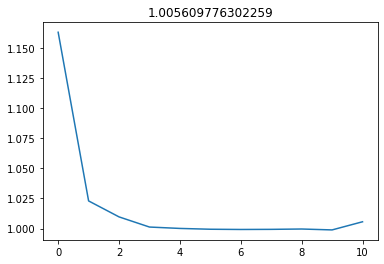

In [18]:
x, obj,temp = FISTA_Backtracking(c,m,n, iter_max = 10, collect_obj = True)
plt.plot(obj); plt.title(obj[-1]); plt.show()

## Tests

<div class="alert alert-block alert-warning">
Exact test
</div>

In [19]:
# Basic data of the instance
M = 4
N = 4
m, n = ones(M)/M, ones(N)/N                        # Uniform distribution of mass
# Matrix of squared distances
c = array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])

Time taken:   0.0 min 0.3795759677886963 s


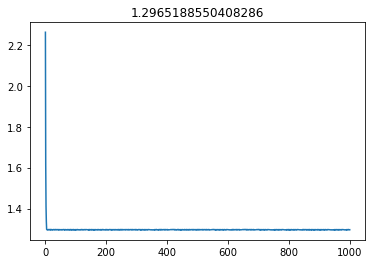

In [20]:
x, obj,temp = FISTA_Backtracking(c,m,n,1000,tol = 1e-8, collect_obj = True)
plt.plot(obj); plt.title(obj[-1]); plt.show()

<div class="alert alert-block alert-warning">
Bigger instance
</div>

In [21]:
# Basic data of the instance
M = 1000
N = 1000

x, y = linspace(0,1,M), linspace(1,2,N)            # Uniform cloud of points
m, n = ones(M)/M, ones(N)/N                        # Uniform distribution of mass
c = cdist(x[:, np.newaxis],y[:, np.newaxis])**2    # Matrix of squared distances

In [22]:
x, v_1, v_2 = zeros((3,M,N))
indicator_simplex(c, m, 1);    prox_i(x,m,n, v_1, v_2);

Time taken:   3.0 min 57.788604974746704 s


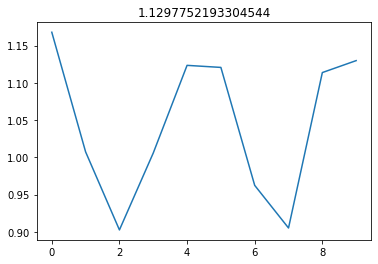

In [23]:
x, obj,temp = FISTA_Backtracking(c,m,n, iter_max = 10, tol = 1e-2, collect_obj = True)
plt.plot(obj); plt.title(obj[-1]); plt.show()

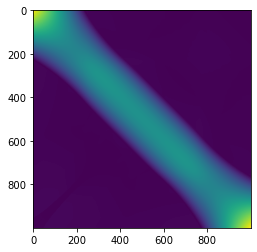

In [26]:
plt.imshow(x); plt.show()

---

# Previous implementations

This implementation of the indicator is more general but takes almost 8 times as the one used above.

In [19]:
def indicator_simplex(x, η, axis = None):
    """
    %
    % This procedure evaluates the indicator function of the constraint set:
    %
    %                  x => 0   AND   1'x = eta
    %
    % When the input 'x' is an array, the computation can vary as follows:
    %  - axis = 0 --> 'x' is processed as a single vector [DEFAULT]
    %  - axis > 0 --> 'x' is processed block-wise along the specified direction
    %
    %  INPUTS
    % ========
    %  x    - ND array
    %  η    - positive, scalar or ND array compatible with the blocks of 'x'
    %  axis - integer, direction of block-wise processing
    """
    
    # check the constraint
    u = x.sum(axis)
    mask = allclose(u, η, rtol=1e-04, atol=1e-05)
    mask &= (u >= 0.0).all()
    
    # evaluate the indicator function
    return 0.0 if mask else inf